In [1]:
import torch
import numpy as np
import pylab as plt
from dal_toolbox.datasets import CIFAR10, CIFAR100
from dal_toolbox.datasets.utils import PlainTransforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
torch.set_float32_matmul_precision('medium')

/home/dhuseljic/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dinov2
# dino_model_name = 'dinov2_vits14' # 21 M params
# dino_model_name = 'dinov2_vitb14' # 86 M params
dino_model_name = 'dinov2_vitl14' # 300 M params
# dino_model_name = 'dinov2_vitg14' # 1100 M params
dino_model = torch.hub.load('facebookresearch/dinov2', dino_model_name)

Using cache found in /home/dhuseljic/.cache/torch/hub/facebookresearch_dinov2_main


In [3]:
# Load data with no transforms
cifar10 = CIFAR10('/datasets', transforms=PlainTransforms(resize=(224, 224)))
cifar100 = CIFAR100('/datasets', transforms=PlainTransforms(resize=(224, 224)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
class DinoFeatureDataset:

    def __init__(self, dino_model, dataset, normalize_features=False, device='cuda'):
        features, labels = self.get_dino_features(dino_model, dataset, device)

        if normalize_features:
            features_mean = features.mean(0)
            features_std = features.std(0) + 1e-9
            features = (features - features_mean) / features_std

        self.features = features
        self.labels = labels
    
    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, idx: int):
        return self.features[idx], self.labels[idx]

    @torch.no_grad()
    def get_dino_features(self, dino_model, dataset, device):
        dataloader = DataLoader(dataset, batch_size=512, num_workers=4)

        features = []
        labels = []
        dino_model.to(device)
        for batch in tqdm(dataloader):
            features.append(dino_model(batch[0].to(device)).to('cpu'))
            labels.append(batch[-1])
        features = torch.cat(features)
        labels = torch.cat(labels)
        return features, labels

In [5]:
train_ds = DinoFeatureDataset(dino_model, cifar10.train_dataset)
val_ds = DinoFeatureDataset(dino_model, cifar10.val_dataset)
test_ds = DinoFeatureDataset(dino_model, cifar10.test_dataset)
ood_ds = DinoFeatureDataset(dino_model, cifar100.test_dataset)

  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_ds.features, train_ds.labels)
print('Logistic Regression:', model.score(test_ds.features, test_ds.labels))

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=20)
model.fit(train_ds.features, train_ds.labels)
print('KNN:', model.score(test_ds.features, test_ds.labels))

from skactiveml.classifier import ParzenWindowClassifier

model = ParzenWindowClassifier(n_neighbors=20, metric='cosine')
model.fit(train_ds.features, train_ds.labels)
print('PWC:', model.score(test_ds.features, test_ds.labels))

Logistic Regression: 0.9801
KNN: 0.9742
PWC: 0.9788


## Logistic and SNGP

### Logistic

In [9]:
from lightning import Trainer
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.deterministic.linear import LinearModel

num_epochs = 10
lr = 1e-1
train_batch_size = 32

net = LinearModel(1024, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
model = DeterministicModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, drop_last=True)
trainer = Trainer(max_epochs=num_epochs)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | LinearModel      | 10.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 955.04it/s, v_num=59, train_loss=0.0239]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 954.19it/s, v_num=59, train_loss=0.0239]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 605.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 773.34it/s]
{'ACC': tensor(0.9814), 'ACE': tensor(0.0119), 'AUROC': tensor(0.9697), 'AUPR': tensor(0.9618)}


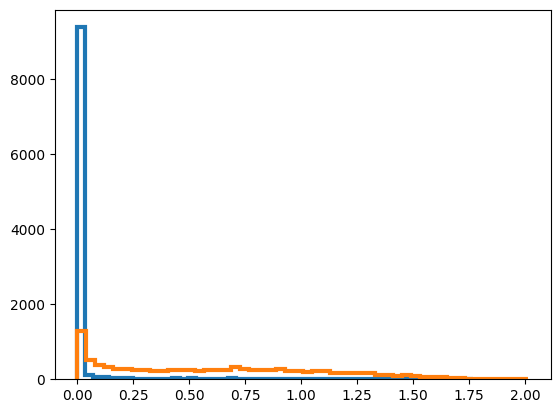

In [10]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

test_loader = DataLoader(test_ds, batch_size=512)
test_predictions = trainer.predict(model, dataloaders=test_loader)
test_logits = torch.cat([pred[0] for pred in test_predictions])
test_labels = torch.cat([pred[1] for pred in test_predictions])
test_log_probas = test_logits.log_softmax(dim=-1)
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_loader = DataLoader(ood_ds, batch_size=512)
ood_predictions = trainer.predict(model, dataloaders=ood_loader)
ood_logits = torch.cat([pred[0] for pred in ood_predictions])
ood_log_probas = ood_logits.log_softmax(dim=-1)
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_logits, test_labels),
    'ACE': AdaptiveCalibrationError()(test_logits, test_labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

### Logistic Sklearn

{'ACC': tensor(0.9801), 'ACE': tensor(0.0159), 'AUROC': tensor(0.9644), 'AUPR': tensor(0.9544)}


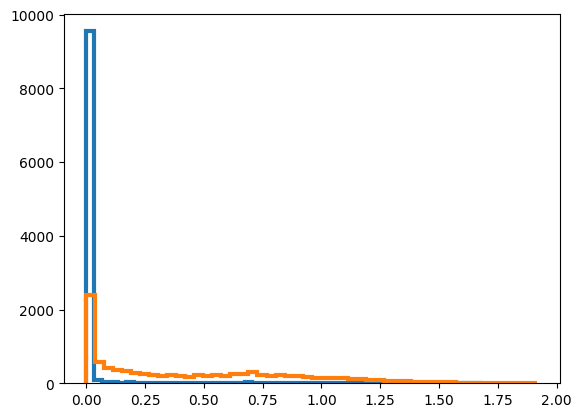

In [11]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

model = LogisticRegression()
model.fit(train_ds.features, train_ds.labels)
model.score(test_ds.features, test_ds.labels)


test_log_probas = torch.from_numpy(model.predict_log_proba(test_ds.features))
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_log_probas = torch.from_numpy(model.predict_log_proba(ood_ds.features))
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_log_probas, test_ds.labels),
    'ACE': AdaptiveCalibrationError()(test_log_probas, test_ds.labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

### GP (RFF + Bayesian Logistic Regression)

In [55]:
from lightning import Trainer
from dal_toolbox.models.sngp import SNGPModel
from dal_toolbox.models.sngp import RandomFeatureGaussianProcess

num_epochs = 10
lr = 1e-1
train_batch_size = 32

net = RandomFeatureGaussianProcess(1024*10, 10, kernel_scale=1, mean_field_factor=50)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, drop_last=True)
trainer = Trainer(max_epochs=num_epochs)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | RandomFeatureGaussianProcess | 10.2 K
1 | loss_fn       | CrossEntropyLoss             | 0     
2 | train_metrics | ModuleDict                   | 0     
3 | val_metrics   | ModuleDict                   | 0     
---------------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Epoch 0:   0%|          | 4/1406 [00:00<00:02, 533.00it/s, v_num=77, train_loss=5.280]

Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 762.51it/s, v_num=77, train_loss=0.00145] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 759.49it/s, v_num=77, train_loss=0.00145]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 366.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 367.75it/s]
{'ACC': tensor(0.9826), 'ACE': tensor(0.0232), 'AUROC': tensor(0.9866), 'AUPR': tensor(0.9853)}


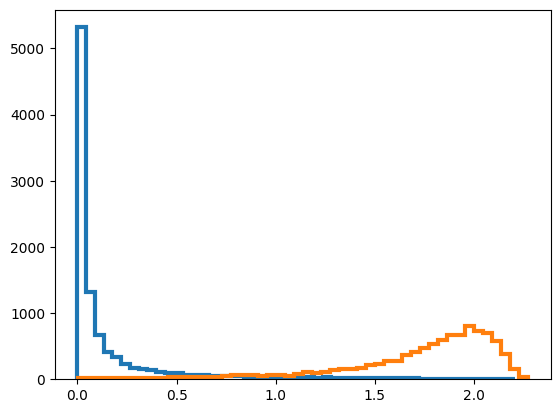

In [56]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

test_loader = DataLoader(test_ds, batch_size=512)
test_predictions = trainer.predict(model, dataloaders=test_loader)
test_logits = torch.cat([pred[0] for pred in test_predictions])
test_labels = torch.cat([pred[1] for pred in test_predictions])
test_log_probas = test_logits.log_softmax(dim=-1)
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_loader = DataLoader(ood_ds, batch_size=512)
ood_predictions = trainer.predict(model, dataloaders=ood_loader)
ood_logits = torch.cat([pred[0] for pred in ood_predictions])
ood_log_probas = ood_logits.log_softmax(dim=-1)
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_logits, test_labels),
    'ACE': AdaptiveCalibrationError()(test_logits, test_labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

### Ensemble

In [14]:
from lightning import Trainer
from dal_toolbox.models.deterministic.linear import LinearModel
from dal_toolbox.models.ensemble import EnsembleModel

num_epochs = 10
lr = 1e-1
train_batch_size = 32

net_list = [LinearModel(1024, 10) for i in range(10)]
optimizer_list = [torch.optim.SGD(net.parameters(), lr=lr) for net in net_list]
lr_scheduler_list = [torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) for optimizer in optimizer_list]
model = EnsembleModel(model_list=net_list, optimizer_list=optimizer_list, lr_scheduler_list=lr_scheduler_list)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, drop_last=True)
trainer = Trainer(max_epochs=num_epochs)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | ModuleList        | 102 K 
1 | loss_fn       | CrossEntropyLoss  | 0     
2 | train_metrics | ModuleDict        | 0     
3 | val_metrics   | ModuleDict        | 0     
4 | val_loss_fn   | GibbsCrossEntropy | 0     
----------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1406/1406 [00:06<00:00, 221.35it/s, v_num=61, train_loss_member0=0.00353, train_loss_member1=0.00363, train_loss_member2=0.00354, train_loss_member3=0.00344, train_loss_member4=0.00374, train_loss_member5=0.00348, train_loss_member6=0.00369, train_loss_member7=0.00363, train_loss_member8=0.00349, train_loss_member9=0.0032]           

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1406/1406 [00:06<00:00, 221.26it/s, v_num=61, train_loss_member0=0.00353, train_loss_member1=0.00363, train_loss_member2=0.00354, train_loss_member3=0.00344, train_loss_member4=0.00374, train_loss_member5=0.00348, train_loss_member6=0.00369, train_loss_member7=0.00363, train_loss_member8=0.00349, train_loss_member9=0.0032]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 650.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 700.35it/s]
{'ACC': tensor(0.9809), 'ACE': tensor(0.0120), 'AUROC': tensor(0.9705), 'AUPR': tensor(0.9631)}


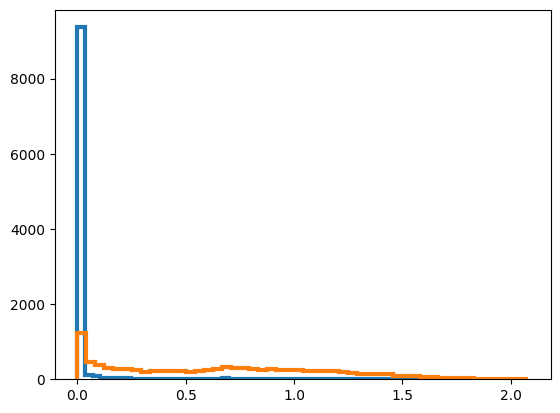

In [15]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR
from dal_toolbox.metrics import ensemble_log_softmax

test_loader = DataLoader(test_ds, batch_size=512)
test_predictions = trainer.predict(model, dataloaders=test_loader)
test_logits = torch.cat([pred[0] for pred in test_predictions])
test_labels = torch.cat([pred[1] for pred in test_predictions])
test_log_probas = ensemble_log_softmax(test_logits)
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_loader = DataLoader(ood_ds, batch_size=512)
ood_predictions = trainer.predict(model, dataloaders=ood_loader)
ood_logits = torch.cat([pred[0] for pred in ood_predictions])
ood_log_probas = ensemble_log_softmax(ood_logits)
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_log_probas, test_labels),
    'ACE': AdaptiveCalibrationError()(test_log_probas, test_labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

### Bagging

In [18]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(LogisticRegression())
model.fit(train_ds.features, train_ds.labels)


BaggingClassifier(estimator=LogisticRegression())

{'ACC': tensor(0.9826), 'ACE': tensor(0.0087), 'AUROC': tensor(0.9779), 'AUPR': tensor(0.9738)}


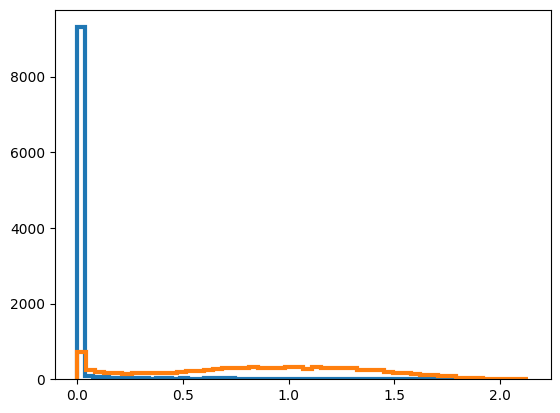

In [22]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

test_probas = torch.from_numpy(model.predict_proba(test_ds.features))
ood_probas = torch.from_numpy(model.predict_proba(ood_ds.features))

test_entropies = - torch.sum(test_probas * test_probas.log(), dim=-1)
ood_entropies = - torch.sum(ood_probas * ood_probas.log(), dim=-1)
print({
    'ACC': Accuracy()(test_probas, test_ds.labels),
    'ACE': AdaptiveCalibrationError()(test_probas.log(), test_ds.labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

## Analysis

In [29]:
import numpy as np
from sklearn.manifold import TSNE
np.random.seed(42)

train_features_tsne = TSNE().fit_transform(train_ds.features)

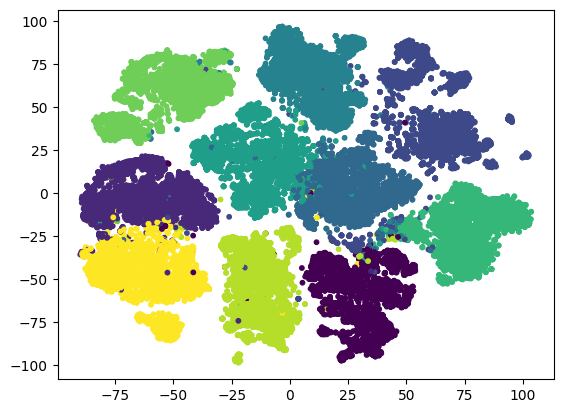

In [30]:
import pylab as plt

plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_ds.labels, s=10)

In [218]:
from sklearn.neighbors import NearestNeighbors

unlabeled_mask = np.array([True] * len(train_ds.features))
labeled_mask = np.array([False] * len(train_ds.features))

buy_indices = np.random.randint(len(train_ds), size=1000)
unlabeled_mask[buy_indices] = False
labeled_mask[buy_indices] = True

cand = train_ds.features[0]

nn = NearestNeighbors(n_neighbors=100)
nn.fit(train_ds.features)
dist, indices = nn.kneighbors(cand.reshape(1, -1))

k_cand = np.zeros(10)
# get indices which are labeled
is_labeled = labeled_mask[indices]
for idx, di in zip(indices[is_labeled], dist[is_labeled]):
    lbl = train_ds.labels[idx]
    inv_dist = 1/di
    print(lbl, inv_dist)
    k_cand[lbl] += 1 * inv_dist

prior = 1
k_cand 
(k_cand + prior) / (k_cand + prior).sum(keepdims=True)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [121]:
labeled_mask[indices]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True]])

In [84]:
# prior, how many samples have seen an label?

tensor(6)


In [28]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.neighbors import NearestNeighbors
import pylab as plt

X, y = make_moons(200, noise=.2)
X = (X - X.mean(0)) / X.std(0)

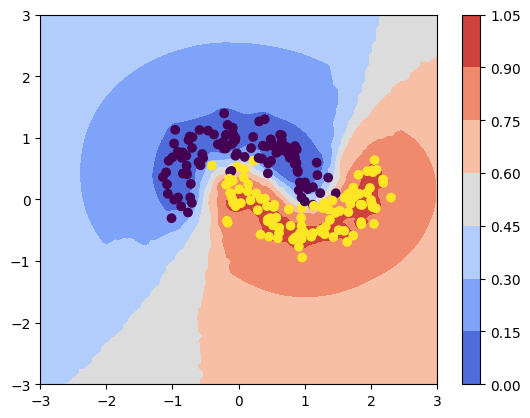

In [31]:
import numpy as np
from sklearn.datasets import make_moons

np.random.seed(1)
X, y = make_moons(200, noise=.2)

nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
dist, indices = nn.kneighbors(X)

def k_func(X, nn):
    K = []
    dist, indices = nn.kneighbors(X)
    for d, idx in zip(dist, indices):
        prior = 10
        k_vec = np.zeros(2) + prior
        for lbl, d_ in zip(y[idx], d):
            k_vec[lbl] += 1/d_
        K.append(k_vec)
    return np.array(K)

xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
K = k_func(zz, nn)

probas = K / K.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm')
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)

# To simulate an update, I need to:
# Check for all samples if the added sample x will be in the neighborhood, not
# feasible, what if I just use all neighbors all the time, ignoring the need of
# a kernel func just use inverse distance


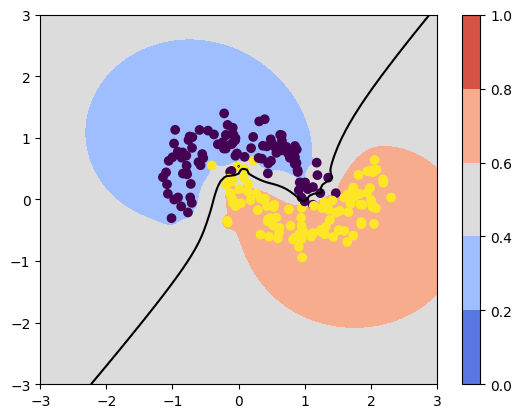

In [55]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels

np.random.seed(1)
X, y = make_moons(200, noise=.2)

def k_func(samples):
    S = pairwise_distances(samples, X)
    # S = pairwise_kernels(samples, X, metric='rbf', gamma=10)

    K = []
    for distances in S:
        prior=1

        k_vec = np.zeros(2) + prior
        for i_cls in range(2):
            dist_cls = distances[y == i_cls]
            inv_dist_cls = 1 / dist_cls
            inv_dist_cls[np.isinf(inv_dist_cls)] = 0
            k_vec[i_cls] += np.sum(inv_dist_cls)
        K.append(k_vec)
    return np.array(K)

xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
K = k_func(zz)

probas = K / K.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.contour(xx, yy, probas[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


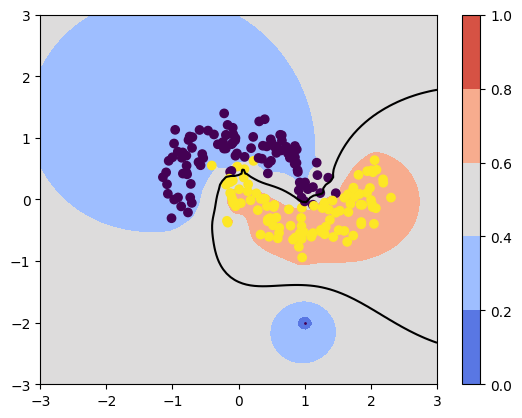

In [24]:
X_new, y_new = np.array([[1, -2]]), np.array([0])
K_new = np.copy(K)

for sample, lbl in zip(X_new, y_new): 
    sim = 1 / pairwise_distances(zz, sample.reshape(1, -1)).squeeze()
    # sim = pairwise_kernels(zz, X_new, metric='rbf', gamma=10).squeeze()
    K_new[:, lbl] = K_new[:, lbl] + 20* sim

probas = K_new / K_new.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.contour(xx, yy, probas[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=1)
plt.show()
